In [6]:

from google.colab import drive
drive.mount('/content/gdrive/') 


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Dnoising Autoencoder

First lets get the utils necessary code from the git repo

In [2]:
%cd gdrive/My\ Drive/ColabFiles/AdversarialAttacks/

/content/gdrive/My Drive/ColabFiles/AdversarialAttacks


In [3]:
!git clone https://github.com/JafarBadour/Adversarial-Attacks-on-Neural-Networks.git .
!git pull

fatal: destination path '.' already exists and is not an empty directory.
Already up to date.


In [4]:
!ls -a

.git/  .gitignore  Models/  Notebooks/  utils/


# Normalization 


map all pixels to 0,1 range


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.1.0'

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)
train_images = train_images/255
test_images = test_images/255

In [9]:
print(train_images.shape)

(60000, 28, 28, 1)


# Denoising Autoencoder structure

Added dropout layer to reduce overfitting it is visible in the graph of loss

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Deconvolution2D, UpSampling2D, Dropout
from keras.models import Model

inputs = Input(shape=(28,28,1))
conv1 = Conv2D(filters=20,kernel_size=(3,3), activation='relu', padding='same') (inputs)
max1 = MaxPool2D((2,2)) (conv1)

drop = Dropout(rate=0.05) (max1)

conv2 = Conv2D(filters=20,kernel_size=(3,3), activation='relu', padding='same') (drop)
max2 = MaxPool2D((2,2)) (conv2)
conv3 = Conv2D(filters=1,kernel_size=(3,3),padding='same',activation='relu') (max2)

deconv3 = Deconvolution2D(filters=1,kernel_size=(3,3),padding='same',activation='relu') (conv3)

upsampling1 = UpSampling2D((2,2)) (deconv3)
deconv2 = Deconvolution2D(filters=20, kernel_size=(3,3), activation='relu', padding='same') (upsampling1)
upsampling2 = UpSampling2D((2,2)) (deconv2)

#deconv2 = Deconvolution2D(filters=20,kernel_size=(3,3), activation='relu') (upsampling1)
inv_input =  Deconvolution2D(filters=1, kernel_size= (3, 3), activation='relu', padding='same') (upsampling2) # probably you will have a problem with padding
encoder = Model(inputs, conv3)
denoising_autoencoder = Model(inputs, inv_input)

denoising_autoencoder.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

In [12]:
denoising_autoencoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 20)        3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 1)           181 

In [13]:
history = denoising_autoencoder.fit(x=train_images,y=train_images,validation_data=(test_images, test_images), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.0278 - acc: 0.5047 - val_loss: 0.0170 - val_acc: 0.5040
Epoch 2/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.0164 - acc: 0.5063 - val_loss: 0.0156 - val_acc: 0.5041
Epoch 3/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.0154 - acc: 0.5065 - val_loss: 0.0152 - val_acc: 0.5039
Epoch 4/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0149 - acc: 0.5065 - val_loss: 0.0149 - val_acc: 0.5046
Epoch 5/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.0147 - acc: 0.5065 - val_loss: 0.0144 - val_acc: 0.5044
Epoch 6/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.0145 - acc: 0.5065 - val_loss: 0.0143 - val_acc: 0.5043
Epoch 7/10
60000/60000 [==============================] - 9s 154us/step - loss: 0.0143 - acc: 0.5065 - val_loss: 0.014

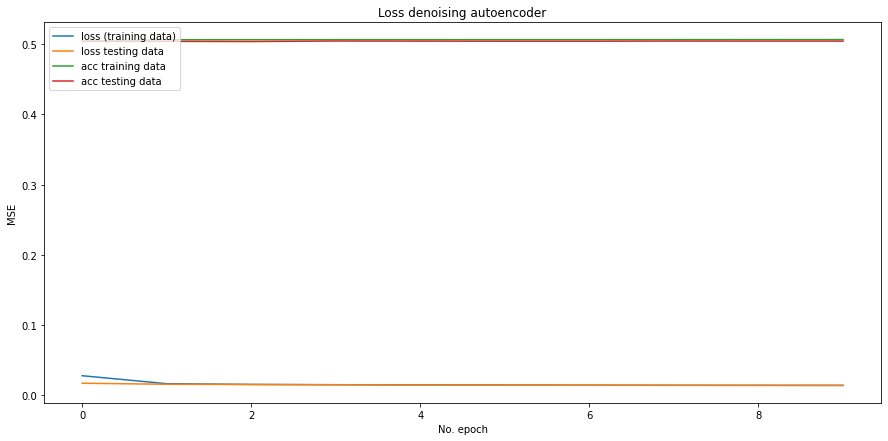

In [14]:
# Plot history: MAE

import matplotlib.pyplot as plt
def plot_history(history):
  plt.rcParams["figure.figsize"] = (15,7)
  plt.plot(history.history['loss'], label='loss (training data)')
  plt.plot(history.history['val_loss'], label='loss testing data')

  plt.plot(history.history['acc'], label='acc training data')
  plt.plot(history.history['val_acc'], label='acc testing data')
  plt.title('Loss denoising autoencoder')
  plt.ylabel('MSE')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

plot_history(history)

In [0]:
denoising_autoencoder.save('./Models/DAE.h5')
DAE = keras.models.load_model('./Models/DAE.h5')

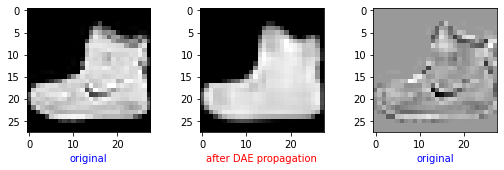

In [18]:
from utils.plot import plot_n_images
original = train_images[0]
denoised = denoising_autoencoder.predict(train_images)[0]
perturb = original - denoised
plot_n_images([original, denoised, perturb])



In [49]:
input_layer= Input(shape=(28,28,1))
x = input_layer
for layer in denoising_autoencoder.layers[1:8]:
  x = layer(x)
encoder= Model(input_layer, x)
encoder.summary()
encoder.save('./Models/encoder.h5')

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  181

In [39]:
print(DAE.layers[0], denoising_autoencoder.layers[0])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f173b533828> <keras.engine.input_layer.InputLayer object at 0x7f17337ee9b0>


In [50]:
enc = keras.models.load_model('./Models/encoder.h5')
enc.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 20)        3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 1)           181

In [29]:

# for layer in denoising_autoencoder.layers[8:]:
#   print(layer.input_shape)

decoder_input = Input(shape=(28,28,1))
x = decoder_input
for layer in denoising_autoencoder.layers[8:]:
  print(layer)
  x = layer(x)

decoder = Model(decoder_input, x)


In [0]:
decoder.save('./Models/decoder.h5')

In [31]:
decoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 multiple                  0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr multiple                  200       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 multiple                  0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr multiple                  181       
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [20]:
import tensorflow as tf
from keras.models import load_model

mdd = load_model('./Models/decoder.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Model_1, Model_2

add two models model_1:

this one will take the layers of the denoisingencoder as an encoder and then will have two dense layers 


model_2:

will take the encoder of the denoising autoencoder as its own encoder and then add two layers of dense 


The main purpose for later is to experiment on such approach to build robust neural networks

In [40]:
!ls -al Models

total 8854
drwx------ 2 root root    4096 Apr 25 18:23 DAE
-rw------- 1 root root  105216 Apr 25 18:23 DAE.h
-rw------- 1 root root  105288 Apr 25 18:40 DAE.h5
-rw------- 1 root root   17168 Apr 25 18:36 decoder.h5
-rw------- 1 root root 4323016 Apr 25 13:56 denoising_autoencoder_ann.h5
-rw------- 1 root root 4466608 Apr 25 13:50 encoder_ann.h5
-rw------- 1 root root   43176 Apr 25 18:40 encoder.h5


In [41]:
x = Input(shape=(28,28,1))
input_layer = x


cnn = [
        Conv2D(filters=10,kernel_size=(3,3),padding='same',activation='relu'),
        MaxPool2D((2,2)),
       Conv2D(filters=10,kernel_size=(3,3),padding='same',activation='relu'),
        MaxPool2D((2,2)),
       Conv2D(filters=10,kernel_size=(3,3),padding='same',activation='relu'),
        MaxPool2D((2,2)),
       Conv2D(filters=5,kernel_size=(3,3),padding='same',activation='relu'),
      
      Flatten(),
      Dense(units=1000, activation='relu'),
      Dense(units=1000, activation='relu'),
      Dense(units=10,activation='softmax')
]
for layer in cnn:
  x = layer(x)

model_1 = Model(input_layer, x)
model_1.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 10)        910       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 10)          0  

In [42]:

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_1.fit(DAE.predict(train_images), train_labels, validation_data=(DAE.predict(test_images), test_labels), epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 154us/step - loss: 0.5857 - acc: 0.7827 - val_loss: 0.4977 - val_acc: 0.8119
Epoch 2/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.4366 - acc: 0.8373 - val_loss: 0.4394 - val_acc: 0.8390
Epoch 3/10
60000/60000 [==============================] - 9s 148us/step - loss: 0.3984 - acc: 0.8522 - val_loss: 0.4253 - val_acc: 0.8443
Epoch 4/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.3762 - acc: 0.8597 - val_loss: 0.4043 - val_acc: 0.8515
Epoch 5/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.3606 - acc: 0.8636 - val_loss: 0.3872 - val_acc: 0.8562
Epoch 6/10
60000/60000 [==============================] - 9s 151us/step - loss: 0.3434 - acc: 0.8694 - val_loss: 0.3888 - val_acc: 0.8587
Epoch 7/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.3316 - acc: 0.8752 - val_loss: 0.3820 - 

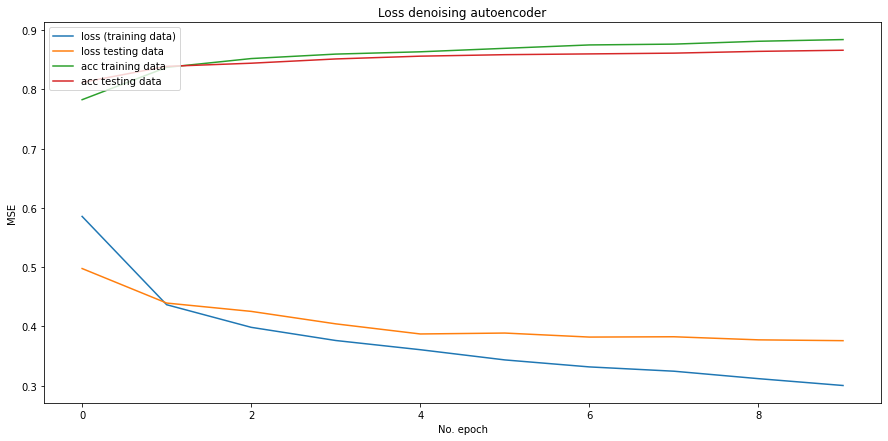

In [43]:
plot_history(history)

In [0]:
input_layer = Input((28,28,1))
x = input_layer
for layer in denoising_autoencoder.layers[1:]:
  x = layer(x)
for layer in model_1.layers[1:]:
  x = layer(x)


In [45]:

el_model_1 = Model(input_layer, x)
el_model_1.summary()
el_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
_,acc = el_model_1.evaluate(train_images, train_labels)
print(acc)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  181

In [0]:
el_model_1.save('./Models/denoising_autoencoder_ann.h5')

# MODEL 2









`

In [0]:
plot_n_images(encoder.predict(test_images)[:3])

model_2 with the same fashion we can do the same



In [ ]:
cnn = [
      Input((7,7,1)),
       Conv2D(filters=10,kernel_size=(3,3),padding='same',activation='relu'),
        MaxPool2D((2,2)),
      
      Flatten(),
      Dense(units=1000, activation='relu'),
      Dense(units=1000, activation='relu'),
      Dense(units=10,activation='softmax')
]

input_layer = cnn[0]
x = cnn[0]
for layer in cnn[1:]:
  x = layer(x)

model_2 = Model(input_layer, x)
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_2.fit(encoder.predict(train_images), train_labels, validation_data=(encoder.predict(test_images), test_labels), epochs=10)

In [ ]:
plot_history(history)

In [ ]:
input_layer = Input((28,28,1))
x = input_layer
for layer in encoder.layers[1:]:
  x = layer(x)
for layer in model_2.layers[1:]:
  x = layer(x)



el_model_2 = Model(input_layer, x)
el_model_2.summary()
el_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
_,acc = el_model_2.evaluate(train_images, train_labels)
print(acc)

In [51]:
el_model_2.save('./Models/encoder_ann.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 116us/step - loss: 0.6256 - acc: 0.7569 - val_loss: 0.5021 - val_acc: 0.8063
Epoch 2/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.4567 - acc: 0.8293 - val_loss: 0.4424 - val_acc: 0.8332
Epoch 3/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.4147 - acc: 0.8445 - val_loss: 0.4299 - val_acc: 0.8372
Epoch 4/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.3881 - acc: 0.8539 - val_loss: 0.4147 - val_acc: 0.8454
Epoch 5/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.3716 - acc: 0.8589 - val_loss: 0.4067 - val_acc: 0.8507
Epoch 6/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.3563 - acc: 0.8651 - val_loss: 0.3915 - val_acc: 0.8522
Epoch 7/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.3446 - acc: 0.8690 - val_loss: 0.3804 - 

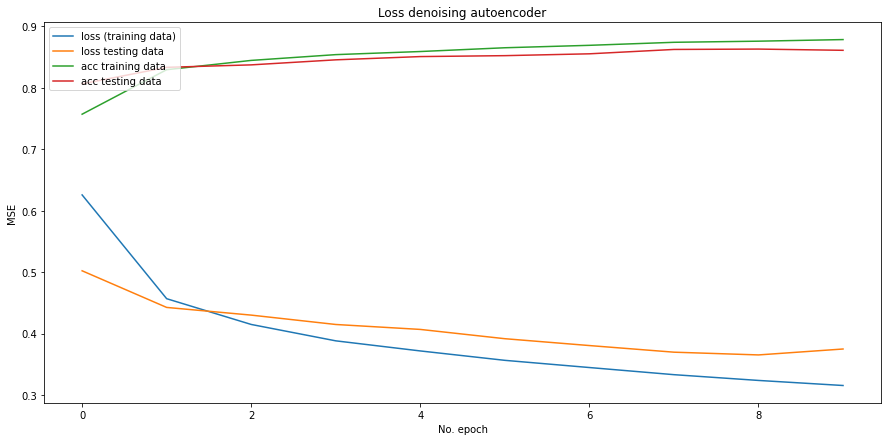

In [52]:
plot_history(history)

In [0]:
input_layer = Input((28,28,1))
x = input_layer
for layer in encoder.layers[1:]:
  x = layer(x)
for layer in model_2.layers[1:]:
  x = layer(x)


In [55]:

el_model_2 = Model(input_layer, x)
el_model_2.summary()
el_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
_,acc = el_model_2.evaluate(train_images, train_labels)
print(acc)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  200       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  3620      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  181

In [0]:
el_model_2.save('./Models/encoder_ann.h5')